In [1]:
%conda env list

/home/farchid/miniconda3/lib/python3.12/site-packages/conda/base/context.py:202: FutureWarning: Adding 'defaults' to channel list implicitly is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly with conda's regular configuration system, e.g. by adding 'defaults' to the list of channels:

  conda config --add channels defaults

For more information see https://docs.conda.io/projects/conda/en/stable/user-guide/configuration/use-condarc.html

  deprecated.topic(

# conda environments:
#
base                   /home/farchid/miniconda3
Hunyuan                /home/farchid/miniconda3/envs/Hunyuan
ViewExtra_Multi        /home/farchid/miniconda3/envs/ViewExtra_Multi
cs323                  /home/farchid/miniconda3/envs/cs323
gof                    /home/farchid/miniconda3/envs/gof
seismic_cs300        * /home/farchid/miniconda3/envs/seismic_cs300
tomosipo               /home/farchid/miniconda3/envs/tomosipo
trellis                /home/

In [1]:
import os
#os.chdir('storseismic')
!pwd

/home/farchid/cs300/seismic_project/storseismic


In [2]:
#! pip install matplotlib

In [3]:
import torch
#from snist.dataset import SNIST
import os
import matplotlib
import matplotlib.pyplot as plt
import sys
import random
import numpy as np

# Get the script's directory
#current_dir = os.path.dirname(os.path.abspath(__file__))

# Ensure the project root is in sys.path
#sys.path.append(current_dir)  # Adds `/mnt/e/university/KAUST/cs300/project`

# Now import the module
import storseismic.utils as utils
from storseismic.utils import SSDataset  # Ensure this is imported


print(os.getcwd())
# Load the file; use a raw string (r"") or double backslashes for Windows paths.
torch.serialization.add_safe_globals([SSDataset])



/home/farchid/cs300/seismic_project/storseismic


In [3]:
data_raw = torch.load(r"/home/farchid/cs300/seismic_project/data_raw/raw_marmousi.pt",weights_only=True)

In [4]:
data_raw.shape

torch.Size([450, 324, 3100])

In [5]:
data_raw_synth = torch.load(r"/home/farchid/cs300/seismic_project/data_raw/raw_synth_1000.pt",weights_only=True)

In [ ]:
#data_raw_synth_1000=data_raw_synth[:1000].clone()

In [8]:
data_raw_synth.shape

torch.Size([1000, 324, 3100])

In [31]:
data_raw_synth.shape

torch.Size([6144, 324, 3100])

In [ ]:
#torch.save(data_raw_synth_1000, r"/mnt/e/storseismic/raw_synth_1000.pt")

In [ ]:
#data_raw_synth[:1000]#.shape

Text(0.5, 1.0, 'Input')

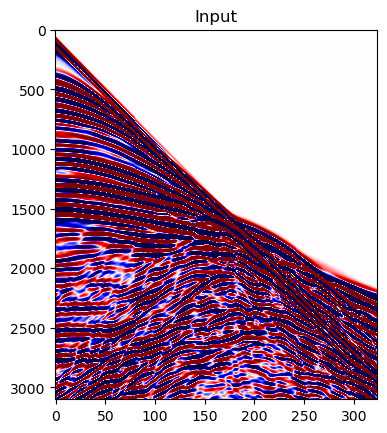

In [13]:
idx=100
vmin_all = -1
vmax_all = 1
#inputs_embeds, labels = data[idx]['inputs_embeds'].T, data[idx]['labels'].T

plt.imshow(sample.T - sample.T.mean(), 
             aspect=0.12, vmin=vmin_all, vmax=vmax_all, cmap='seismic', interpolation='none')
plt.title("Input")


Text(0.5, 1.0, 'Input')

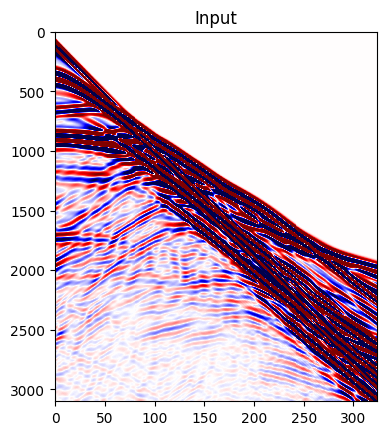

In [9]:
idx=100
vmin_all = -1
vmax_all = 1
sample_synth = data_raw_synth[200]
#inputs_embeds, labels = data[idx]['inputs_embeds'].T, data[idx]['labels'].T

plt.imshow(sample_synth.T - sample_synth.T.mean(), 
             aspect=0.12, vmin=vmin_all, vmax=vmax_all, cmap='seismic', interpolation='none')
plt.title("Input")

In [16]:
sample_synth.shape

torch.Size([324, 3100])

In [ ]:
#data_test = torch.load(r"/mnt/e/storseismic/pretrain/test_data.pt",weights_only=True)
#data = torch.load(r"/mnt/e/storseismic/pretrain/train_data.pt",weights_only=True)

In [10]:
def filter_AGC(data,length_filter,exp1=1,exp2=1):
    #length_filter=20
    zeros=np.tile(100000,(324,int(length_filter/2)))
    padded=np.concatenate((zeros,data,zeros),axis=1)
    desired_rms=1.9
    section_gained=np.ones((padded.shape[0],int(padded.shape[1]-length_filter)),dtype=np.float32)
    for elem1,i in enumerate(section_gained):
        rms_amp=np.ones(int(padded.shape[1]-length_filter),dtype=np.float32)
        for elem2,j in enumerate(section_gained[elem1]):
            window=padded[elem1][elem2:elem2+length_filter]
            rms=[]
            for elem3,k in enumerate(window):
                if k==100000:
                    continue 
                elif k==0:
                    k=0.00000001
                if elem3< (padded.shape[1]-length_filter):
                    squared=abs(k)**exp1
                    rms.append(squared)  
            #print(elem1)
            #print(np.size(rms))
            rms_l=desired_rms/(np.float_power((np.sum(rms)/len(rms)),exp2))
            rms_amp[elem2]=rms_l
            #print(rms_l,elem2)
        section_gained[elem1]=rms_amp
    return section_gained

In [12]:
! pip install scipy

  Using cached scipy-1.15.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached scipy-1.15.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.6 MB)


In [13]:
import numpy as np
from scipy.signal import butter, filtfilt

def lowpass_filter_trace(trace, cutoff_freq, fs, order=2):
    """
    Apply low-pass Butterworth filter to a trace.

    Parameters:
        trace: 1D numpy array (one seismic trace)
        cutoff_freq: cutoff frequency (Hz)
        fs: original sampling rate (Hz)
        order: filter order

    Returns:
        Filtered trace
    """
    nyq = 0.5 * fs
    normal_cutoff = cutoff_freq / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, trace)

def downsample_trace(trace, factor):
    return trace[::factor]

def process_seismic_section(section, fs, downsample_factor, cutoff_freq=None):
    """
    Apply low-pass filter and downsample each trace of a seismic section.

    Parameters:
        section: 2D numpy array (n_samples x n_traces)
        fs: original sampling rate (Hz)
        downsample_factor: integer
        cutoff_freq: cutoff frequency (Hz). If None, uses Nyquist of downsampled signal.

    Returns:
        Processed seismic section
    """
    if cutoff_freq is None:
        cutoff_freq = 0.5 * (fs / downsample_factor)

    processed_section = []
    for i in range(section.shape[1]):  # iterate over traces (columns)
        trace = section[:, i]
        filtered = lowpass_filter_trace(trace, cutoff_freq, fs)
        downsampled = downsample_trace(filtered, downsample_factor)
        processed_section.append(downsampled)

    return np.stack(processed_section, axis=1)  # shape: [new_samples, n_traces]


In [15]:
!pip install tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)


In [17]:
len(data_raw_synth)

1000

In [71]:
downsample_factor = 5
idx=50
vmin_all = -1
vmax_all = 1
sample = data_raw_synth[idx].numpy()
section_gained = filter_AGC(sample, 60, exp1=0.88, exp2=0.88)
section_gained = section_gained.T * sample.T
data_noise_norm = (norm_max - norm_min) * ((section_gained - np.min(section_gained)) / 
                    (np.max(section_gained) - np.min(section_gained))) + norm_min

#sample_inp = data[idx]['inputs_embeds'].numpy()
#section_gained_inp = filter_AGC(sample, 60, exp1=0.8, exp2=0.8)
#section_gained_inp = section_gained_inp.T * sample_inp.T
#data_noise_norm_input = (norm_max - norm_min) * ((section_gained_inp - np.min(section_gained_inp)) / 
#                          (np.max(section_gained_inp) - np.min(section_gained_inp))) + norm_min

processed = process_seismic_section(data_noise_norm, fs, downsample_factor)
processed2 = process_seismic_section(processed, fs, 4)



[[ 0.01340664  0.01339986  0.0134052  ...  0.01341641  0.01341641
   0.01341641]
 [ 0.01306962  0.01195736  0.01295354 ...  0.01341641  0.01341641
   0.01341641]
 [ 0.01044638  0.01264557  0.01157437 ...  0.01341641  0.01341641
   0.01341641]
 ...
 [-0.14237433 -0.13524051 -0.10407516 ... -0.54630172 -0.51615489
  -0.37317374]
 [ 0.03063618  0.08667645  0.12070961 ...  0.01922629 -0.08448818
  -0.29671832]
 [ 0.10016742  0.02936467 -0.04440474 ... -0.17717273 -0.20159334
   0.03312061]]


Text(0.5, 1.0, 'Label')

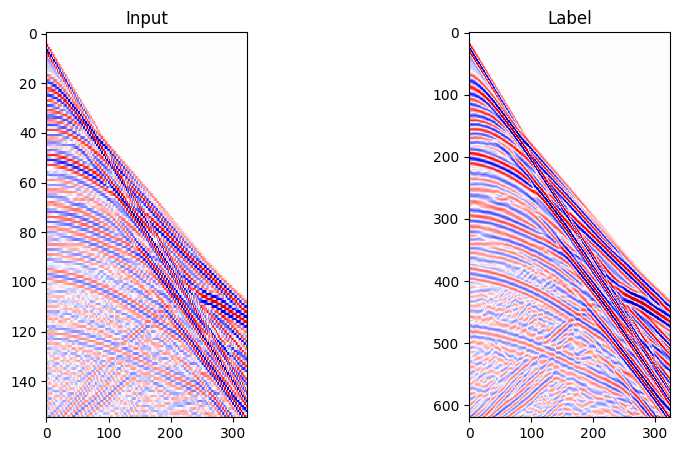

In [72]:
inputs_embeds, labels = processed2, processed


f, ax = plt.subplots(1, 2, figsize=(10, 5))
print(inputs_embeds)
ax[0].imshow(inputs_embeds - inputs_embeds.mean(), 
             aspect=4, vmin=vmin_all, vmax=vmax_all, cmap='seismic', interpolation='none')
ax[0].set_title("Input")
ax[1].imshow(labels - labels.mean(), 
             aspect=1, vmin=vmin_all, vmax=vmax_all, cmap='seismic', interpolation='none')
ax[1].set_title("Label")

In [73]:
idx=150
downsample_factor = 5
vmin_all = -1
vmax_all = 1
sample = data_raw[idx].numpy()
section_gained = filter_AGC(sample, 60, exp1=0.79, exp2=0.79)
section_gained = section_gained.T * sample.T
data_noise_norm = (norm_max - norm_min) * ((section_gained - np.min(section_gained)) / 
                    (np.max(section_gained) - np.min(section_gained))) + norm_min

#sample_inp = data[idx]['inputs_embeds'].numpy()
#section_gained_inp = filter_AGC(sample, 60, exp1=0.8, exp2=0.8)
#section_gained_inp = section_gained_inp.T * sample_inp.T
#data_noise_norm_input = (norm_max - norm_min) * ((section_gained_inp - np.min(section_gained_inp)) / 
#                          (np.max(section_gained_inp) - np.min(section_gained_inp))) + norm_min

processed = process_seismic_section(data_noise_norm, fs, downsample_factor)
processed2 = process_seismic_section(processed, fs, 4)




#inputs_embeds, labels = data[idx]['inputs_embeds'].T, data[idx]['labels'].T


[[ 0.1407463   0.14074602  0.14075566 ...  0.14076209  0.14076209
   0.14076209]
 [ 0.14100106  0.14055062  0.14065051 ...  0.14076209  0.14076209
   0.14076209]
 [ 0.13777853  0.14038248  0.14070925 ...  0.14076209  0.14076209
   0.14076209]
 ...
 [ 0.07588991  0.0744479   0.08157899 ...  0.51308111  0.55767697
   0.49216657]
 [-0.0664858  -0.06019476 -0.05868534 ...  0.12246407  0.15661484
   0.2885484 ]
 [ 0.11416756  0.09045456  0.07219572 ... -0.12223373 -0.04218195
  -0.03389376]]


Text(0.5, 1.0, 'Label')

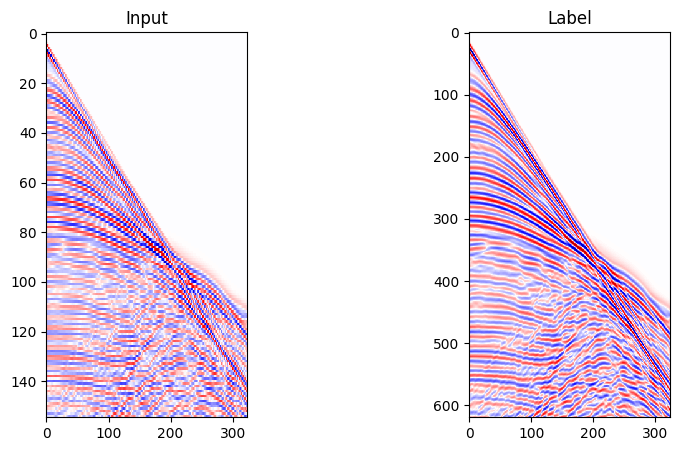

In [74]:
inputs_embeds, labels = processed2, processed


f, ax = plt.subplots(1, 2, figsize=(10, 5))
print(inputs_embeds)
ax[0].imshow(inputs_embeds - inputs_embeds.mean(), 
             aspect=4, vmin=vmin_all, vmax=vmax_all, cmap='seismic', interpolation='none')
ax[0].set_title("Input")
ax[1].imshow(labels - labels.mean(), 
             aspect=1, vmin=vmin_all, vmax=vmax_all, cmap='seismic', interpolation='none')
ax[1].set_title("Label")

In [75]:
import torch
import numpy as np
import os
from tqdm import tqdm

# Config
norm_max = 1
norm_min = -1
fs = 1
downsample_factor = 5
save_path = "seismic_samples/"
os.makedirs(save_path, exist_ok=True)

# Replace with your actual dataset
# # Total number of samples you want to process
all_inputs = []
all_labels = []

# Dummy filter_AGC and process_seismic_section (replace with real ones)

#def filter_AGC(data, window_size, exp1=0.8, exp2=0.8):
 #   return np.exp(-data**2 / window_size)

#def process_seismic_section(section, fs, downsample_factor):
 #   return section[::downsample_factor, :]

# Process and save each sample
for idx in tqdm(range(len(data_raw_synth))):
    sample = data_raw_synth[idx].numpy()
    section_gained = filter_AGC(sample, 60, exp1=0.88, exp2=0.88)
    section_gained = section_gained.T * sample.T
    data_noise_norm = (norm_max - norm_min) * ((section_gained - np.min(section_gained)) / 
                      (np.max(section_gained) - np.min(section_gained))) + norm_min

    #sample_inp = data[idx]['inputs_embeds'].numpy()
    #section_gained_inp = filter_AGC(sample, 60, exp1=0.8, exp2=0.8)
    #section_gained_inp = section_gained_inp.T * sample_inp.T
    #data_noise_norm_input = (norm_max - norm_min) * ((section_gained_inp - np.min(section_gained_inp)) / 
    #                          (np.max(section_gained_inp) - np.min(section_gained_inp))) + norm_min

    processed = process_seismic_section(data_noise_norm, fs, downsample_factor)
    processed2 = process_seismic_section(processed, fs, 4)

    all_inputs.append(torch.tensor(processed, dtype=torch.float32))       # shape: [188, 324] → downsampled
    all_labels.append(torch.tensor(processed2, dtype=torch.float32)) # shape: [376, 324]

    


# Stack into tensors
inputs_tensor = torch.stack(all_inputs)   # [N, H_in, W]
labels_tensor = torch.stack(all_labels)   # [N, H_out, W]

# Save in a single .pt file
torch.save({
    'inputs': inputs_tensor,
    'labels': labels_tensor
}, os.path.join(save_path,'seismic_dataset_super_resolution_synth.pt'))

print("✅ Dataset saved to 'seismic_dataset_super_resolution_train.pt'")

# Replace with your actual dataset
 # Total number of samples you want to process
all_inputs = []
all_labels = []

# Process and save each sample
for idx in tqdm(range(len(data_raw))):
    sample = data_raw[idx].numpy()
    section_gained = filter_AGC(sample, 60, exp1=0.79, exp2=0.79)
    section_gained = section_gained.T * sample.T
    data_noise_norm = (norm_max - norm_min) * ((section_gained - np.min(section_gained)) / 
                      (np.max(section_gained) - np.min(section_gained))) + norm_min

    #sample_inp = data[idx]['inputs_embeds'].numpy()
    #section_gained_inp = filter_AGC(sample, 60, exp1=0.8, exp2=0.8)
    #section_gained_inp = section_gained_inp.T * sample_inp.T
    #data_noise_norm_input = (norm_max - norm_min) * ((section_gained_inp - np.min(section_gained_inp)) / 
    #                          (np.max(section_gained_inp) - np.min(section_gained_inp))) + norm_min

    processed = process_seismic_section(data_noise_norm, fs, downsample_factor)
    processed2 = process_seismic_section(processed, fs, 4)

    all_inputs.append(torch.tensor(processed, dtype=torch.float32))       # shape: [188, 324] → downsampled
    all_labels.append(torch.tensor(processed2, dtype=torch.float32)) # shape: [376, 324]

# Stack into tensors
inputs_tensor = torch.stack(all_inputs)   # [N, H_in, W]
labels_tensor = torch.stack(all_labels)   # [N, H_out, W]

# Save in a single .pt file
torch.save({
    'inputs': inputs_tensor,
    'labels': labels_tensor
}, os.path.join(save_path,'seismic_dataset_super_resolution_field.pt'))
print("✅ Dataset saved to 'seismic_dataset_super_resolution_test.pt'")





100%|██████████| 1000/1000 [9:50:12<00:00, 35.41s/it] 


✅ Dataset saved to 'seismic_dataset_super_resolution_train.pt'


100%|██████████| 450/450 [4:19:49<00:00, 34.64s/it]  


✅ Dataset saved to 'seismic_dataset_super_resolution_test.pt'


In [25]:
save_path = "seismic_samples/"
os.makedirs(save_path, exist_ok=True)

field=torch.load(os.path.join(save_path,'seismic_dataset_super_resolution_field.pt'))
synth=torch.load(os.path.join(save_path,'seismic_dataset_super_resolution_synth.pt'))

In [26]:
field['inputs'].shape
#field['labels'].shape

torch.Size([450, 620, 324])

Text(0.5, 1.0, 'Label')

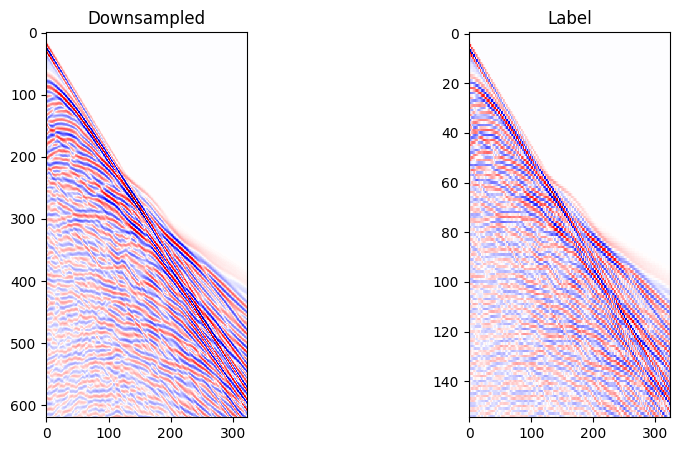

In [29]:
#f, ax = plt.subplots(1, 2, figsize=(10, 5))
idx=385
vmin_all = -1
vmax_all = 1
f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(field['inputs'][idx] - field['inputs'][idx].mean(), 
             aspect=1, vmin=vmin_all, vmax=vmax_all, cmap='seismic', interpolation='none')
ax[0].set_title("Downsampled")
ax[1].imshow(field['labels'][idx] - field['labels'][idx].mean(), 
             aspect=4, vmin=vmin_all, vmax=vmax_all, cmap='seismic', interpolation='none')
ax[1].set_title("Label")